# Elevation Map Rough Draft

This is a rough draft of the elevation map.  Just proving the concepts really making sure everything is on the correct path

In [19]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import geoplot as gplt
import geopandas as gpd
import pylas
import gc
from shapely.geometry import Point
import pandas as pd
import utm
import zipfile
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize

epsg = 4289
lasPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

In [2]:
neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')

Extent: (-90.14003111, 29.86560481, -89.87, 30.08)


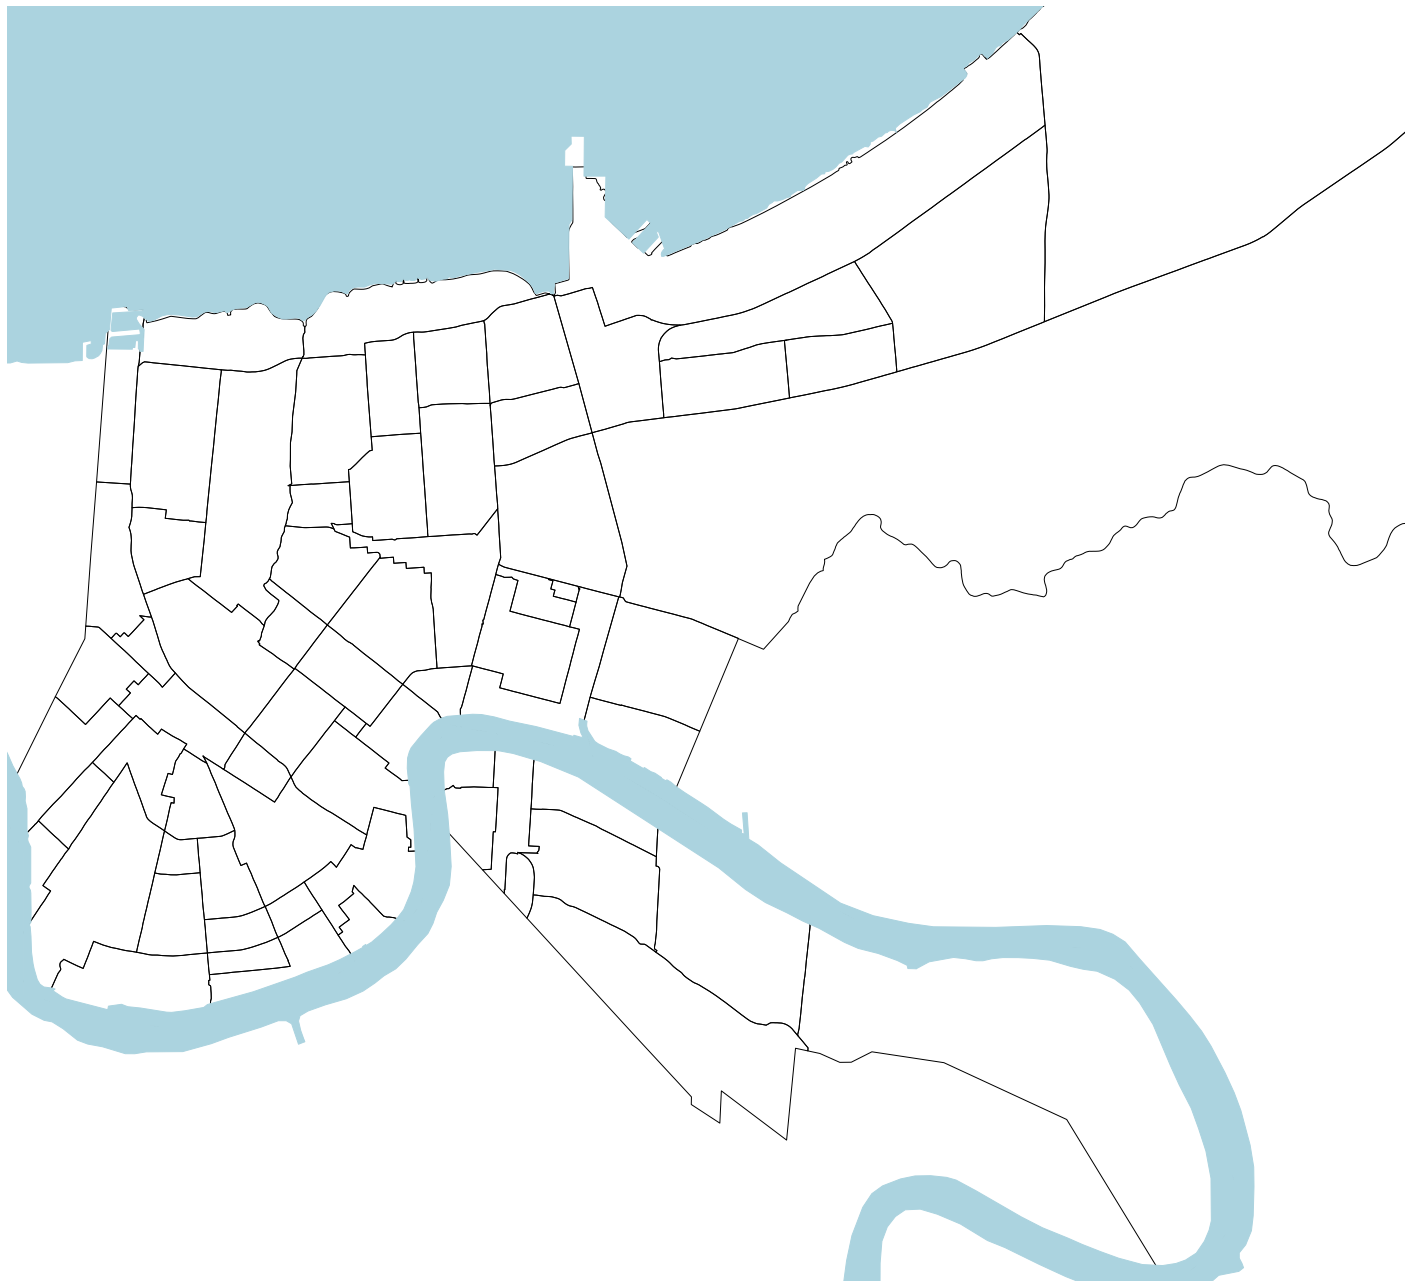

In [3]:
projection = gplt.Mercator()
fig, ax = plt.subplots(figsize=(28,18), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)

gplt.polyplot(neighborhoodDf, edgecolor='black', projection=projection, ax=ax, extent=extent)
gplt.polyplot(waterDf,ax=ax, \
                zorder=11, projection=projection, extent=extent, edgecolor='#abd3df', facecolor='#abd3df')
   

fig.tight_layout()

print("Extent:", extent)

In [4]:
xmlFiles = pd.read_pickle('./xmlFilesGeo.pickle')

#only load overlapped
xmlFiles = xmlFiles[xmlFiles['overLap']]

fileNames = [(x,x.replace('.zip','.las')) for x in [x.split('/')[-1] for x in xmlFiles['ftpFileName'].to_list()]]

del xmlFiles
print("File count: ", len(fileNames))

File count:  292


In [5]:
#probability of point being choosen
desiredPointsPerTile = 500

class LoadFileException(Exception):
    pass

def loadFile(fileName):
    
    with zipfile.ZipFile(lasPath + fileName[0]) as f:
        rawData = f.read(fileName[1])
        lasData = pylas.read(rawData)
    
    del rawData
    
    ground = lasData.classification == 2
    pointCount = np.count_nonzero(ground)
    
    #include low vegitation if not enough ground points
    if pointCount < desiredPointsPerTile:
        ground = ground | (lasData.classification == 3) 
    
    pointCount = np.count_nonzero(ground)
    if  pointCount == 0:
        raise(LoadFileException('No ground/lowveg points in this dataset'))
    
    X = lasData.x[ground]
    Y = lasData.y[ground]
    Z = lasData.z[ground]
    if X.shape[0] <= desiredPointsPerTile:
        randSample = np.repeat(np.True_, X.shape[0])
    else:
        pointProb = desiredPointsPerTile / float(X.shape[0])
        randSample = np.random.choice([np.True_,np.False_], X.shape[0], p=[pointProb,1-pointProb])
    
    X = X[randSample]
    Y = Y[randSample]
    Z = Z[randSample]
    
    df = gpd.GeoDataFrame(Z, geometry=gpd.points_from_xy(X,Y), columns=['elevation']).set_crs(32215).to_crs(epsg)
    
    return df

In [6]:
fullFileName = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/USGS_LPC_LA_UpperDeltaPlain_2017_15ryp755120_LAS_2018.zip'
fileName = fullFileName.split('/')[-1]
lasDf = loadFile((fileName, fileName.replace('.zip','.las')))
lasDf.head()

,elevation,geometry
0,4.73,POINT (-90.14487 29.92020)
1,1.60,POINT (-90.14514 29.92054)
2,1.59,POINT (-90.14616 29.92079)
3,1.18,POINT (-90.14622 29.92102)
4,1.68,POINT (-90.14539 29.92005)


In [7]:
%%time
dfs = []
for fileName in fileNames:
    try:
        dfs.append(loadFile(fileName))
    except LoadFileException as e:
        print("\n%s failed: %s" % (fileName[0],str(e)))
    
    
    print('.', end='')
    gc.collect()

print("Processed files: ", len(dfs))
lasDf = pd.concat(dfs)
print("Points Processed: ", len(lasDf))

....................................................................................................................................................................................................................................................................................................Processed files:  292
Points Processed:  145688
CPU times: user 5min 28s, sys: 28.7 s, total: 5min 57s
Wall time: 6min 26s


In [8]:
lasDf.head()

,elevation,geometry
0,-1.11,POINT (-89.89286 30.05069)
1,0.27,POINT (-89.89369 30.05059)
2,-0.96,POINT (-89.89300 30.04960)
3,-0.95,POINT (-89.89300 30.04961)
4,-0.85,POINT (-89.89296 30.05009)


In [21]:
lasDf['elevationFeet'] = lasDf['elevation'] * 3.28084
norm = Normalize(vmin=-3, vmax=3, clip=True)

lasDf['normElevationFeet'] = norm(lasDf['elevationFeet'], clip=True)
lasDf.head()

,elevation,geometry,elevationFeet,aboveSeaLevel,twoSlopElevationFeet,normElevationFeet
0,-1.11,POINT (-89.89286 30.05069),-3.641732,0,0.000000,0.000000
1,0.27,POINT (-89.89369 30.05059),0.885827,1,0.647638,0.647638
2,-0.96,POINT (-89.89300 30.04960),-3.149606,0,0.000000,0.000000
3,-0.95,POINT (-89.89300 30.04961),-3.116798,0,0.000000,0.000000
4,-0.85,POINT (-89.89296 30.05009),-2.788714,0,0.035214,0.035214


/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: UserWarning: Use the colorbar set_ticks() method instead.
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Extent: (-90.14003111, 29.86560481, -89.87, 30.08)


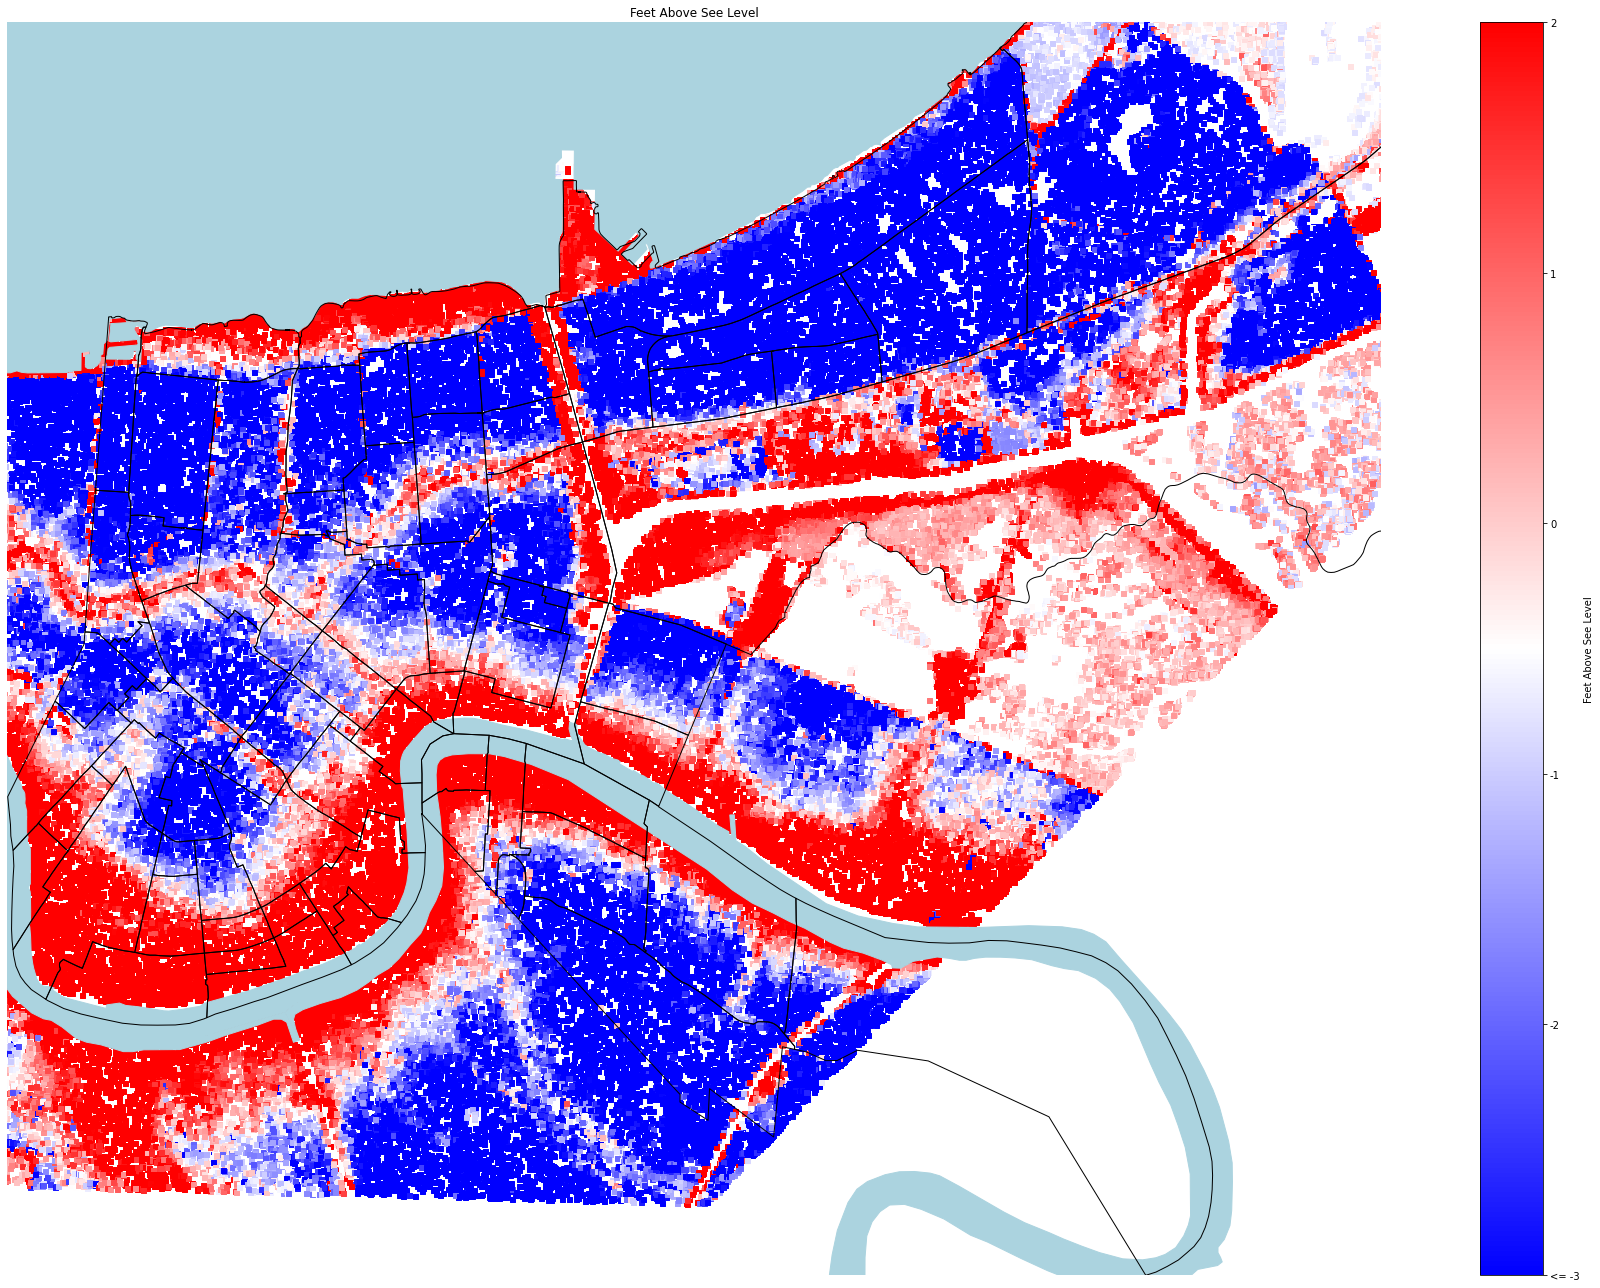

In [27]:
projection = gplt.Mercator()
fig, ax = plt.subplots(figsize=(28,18), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)


gplt.pointplot(lasDf,hue='normElevationFeet', legend=True, ax=ax, projection=projection, zorder=20, extent=extent, cmap='bwr', marker=',')
gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df', extent=extent, zorder=22)
gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor=(1,0,0,0), projection=projection, ax=ax, extent=extent, zorder=23)

cbar = fig.get_axes()[-1]
#cbar.set_yticklabels(norm.inverse(cbar.get_yticks()))
#cbar.set_yticks((-3,-2,-1,0,1,2,3))
#cbar.set_yticklabels(('<= -3', '-2', '-1', '0', '1', '2', '>= 3'))
cbar.set_ylabel('Feet Above See Level') 

ax.set_title('Feet Above See Level')
fig.tight_layout()

print("Extent:", extent)

In [ ]:
lasDf.count()

In [ ]:
lasDf.count()